In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
# # Xavier initialization
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
#         torch.nn.init.xavier_uniform_(self.fc2.weight)
# Normal distribution initialization
        torch.nn.init.normal_(self.fc1.weight)
        torch.nn.init.normal_(self.fc2.weight)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x



def to_one_hot(i, n):
    """Convert an integer to one-hot vector"""
    a = torch.zeros(n)
    a[i] = 1
    return a

def from_one_hot(a):
    """Convert a one-hot vector to an integer"""
    return torch.argmax(a).item()

def generate_dataset_one_hot(p, alpha, seed, operation):
    """Generate a dataset with one-hot encoded inputs and outputs"""
    eye = torch.eye(p)
    dataset = []
    for a in range(p):
        for b in range(p):
            #c = (a + b) % p
            c = operation(a, b) % p

            ab_encoded = torch.cat((eye[a], eye[b]))
            c_encoded = to_one_hot(c, p)
            dataset.append((ab_encoded, c_encoded))
    dataset = [(ab.clone().detach(), c.clone().detach()) for ab, c in dataset]
    np.random.seed(seed) #Ensures reproducibility, can be changed by changing seed=42
    np.random.shuffle(dataset)
    train_set, test_set = train_test_split(dataset, train_size=alpha, shuffle=False)
    train_input, train_output = zip(*train_set)
    test_input, test_output = zip(*test_set)
    return list(train_input), list(train_output), list(test_input), list(test_output)

def decode_dataset(train_input, train_output, test_input, test_output):
    """Decode the dataset from one-hot encoded vectors to integers"""
    train_input_decoded = [(from_one_hot(a[:p]), from_one_hot(a[p:])) for a in train_input]
    train_output_decoded = [from_one_hot(c) for c in train_output]
    test_input_decoded = [(from_one_hot(a[:p]), from_one_hot(a[p:])) for a in test_input]
    test_output_decoded = [from_one_hot(c) for c in test_output]
    return train_input_decoded, train_output_decoded, test_input_decoded, test_output_decoded


def train_network(model, train_input, train_output, test_input, test_output, n_epochs, learning_rate):
    # Convert lists to tensors and move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_input = torch.stack(train_input).to(device)
    train_output = torch.stack(train_output).to(device)
    test_input = torch.stack(test_input).to(device)
    test_output = torch.stack(test_output).to(device)

    criterion = nn.CrossEntropyLoss()

    # Define the optimizer as AdamW
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), weight_decay=wd)
    scheduler = LambdaLR(optimizer, lambda step: min(step/100, 1))

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    last_layer_norms = []  # Step 1: Initialize an empty list for last layer norms

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs_train = model(train_input)
        loss_train = criterion(outputs_train, train_output)
        loss_train.backward()
        optimizer.step()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            outputs_test = model(test_input)
            loss_test = criterion(outputs_test, test_output)

        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())


        predicted_train = torch.argmax(outputs_train.data, dim=1)
        predicted_test = torch.argmax(outputs_test.data, dim=1)
        train_output_indices = torch.argmax(train_output, dim=1)
        test_output_indices = torch.argmax(test_output, dim=1)
        train_correct = (predicted_train == train_output_indices).sum().item()
        test_correct = (predicted_test == test_output_indices).sum().item()
        train_acc = train_correct / len(train_output)
        test_acc = test_correct / len(test_output)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Step 2: Compute the L2 norm of the last layer and append to the list
        last_layer_norm = torch.norm(model.fc2.weight.data).item()
        last_layer_norms.append(last_layer_norm)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {loss_train.item():.8f}, Test Loss: {loss_test.item():.8f}, Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%')

    # Step 3: Return the last_layer_norms list along with other metrics
    return train_losses, test_losses, train_accuracies, test_accuracies, last_layer_norms



Fri Aug 25 23:57:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def create_model(p, hidden_dim=128):
    input_dim = 2 * p
    output_dim = p
    model = MLP(input_dim, hidden_dim, output_dim).to(device)  # Move the model to the device
    return model

def run_experiment(model, p, alpha, n_epochs, learning_rate, seed, train_network,operation):
    # Generate the dataset with one-hot encoded outputs
    train_input, train_output, test_input, test_output = generate_dataset_one_hot(p, alpha, seed,operation)

    train_losses, test_losses, train_accuracies, test_accuracies, last_layer_norms = train_network(
        model, train_input, train_output, test_input, test_output, n_epochs, learning_rate
    )

    return train_losses, test_losses, train_accuracies, test_accuracies, last_layer_norms

def plot_loss(train_losses, test_losses, p, seed):
    plt.figure(figsize=(4, 4))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.yscale('log')  # Make y-axis logarithmic
    plt.legend()
    plt.title(f'Loss for p={p}, seed={seed}, polynomial={operation}')
    #plt.savefig(f"{images_dir}/loss_p_{p}_seed_{seed}_run_{run}.png")
    #plt.close()
    plt.show()


def plot_accuracy(train_accuracies, test_accuracies, p, seed):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.title(f'Accuracy for p={p}, seed={seed},polynomial={operation}')
   # plt.savefig(f'{images_dir}/accuracy_p_{p}_seed_{seed}_run_{run}.png')
    #plt.close()
    plt.show()



In [3]:
#Define set of operations

def add(a, b):
    return a + b

def multiply(a, b):
    return a * b

def polynomial(a, b):
    return  a**2 +b**2 + a*b


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Running experiment for p=97, seed=42,Polynomial=<function add at 0x798f1a1e53f0>
Epoch [100/20000], Train Loss: 4.80415058, Test Loss: 6.30982733, Train Acc: 4.29%, Test Acc: 0.53%
Epoch [200/20000], Train Loss: 3.71105647, Test Loss: 5.40892410, Train Acc: 23.15%, Test Acc: 0.00%
Epoch [300/20000], Train Loss: 2.03834534, Test Loss: 5.98752260, Train Acc: 67.35%, Test Acc: 0.37%
Epoch [400/20000], Train Loss: 0.28512934, Test Loss: 3.27307677, Train Acc: 99.89%, Test Acc: 25.74%
Epoch [500/20000], Train Loss: 0.08588115, Test Loss: 1.16631997, Train Acc: 100.00%, Test Acc: 78.67%
Epoch [600/20000], Train Loss: 0.03719957, Test Loss: 0.53657538, Train Acc: 100.00%, Test Acc: 94.16%
Epoch [700/20000], Train Loss: 0.01771149, Test Loss: 0.29452729, Train Acc: 100.00%, Test Acc: 97.90%
Epoch [800/20000], Train Loss: 0.00902853, Test Loss: 0.17840946, Train Acc

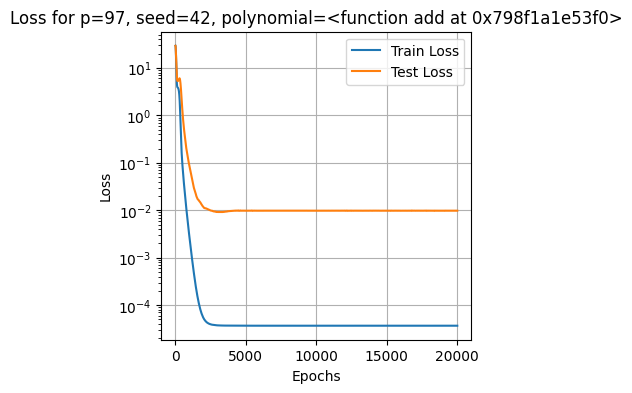

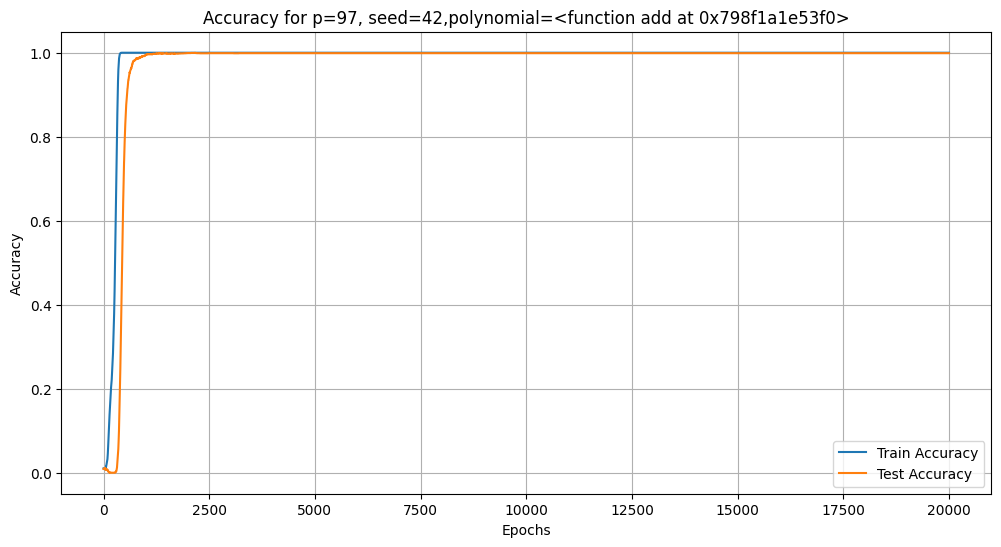

dict_keys([(97, 42)])
[112.2559814453125, 112.24335479736328, 112.21809387207031, 112.18021392822266, 112.12972259521484, 112.06664276123047, 111.99097442626953, 111.90274047851562, 111.80192565917969, 111.68854522705078, 111.56256866455078, 111.42398071289062, 111.27274322509766, 111.10882568359375, 110.93222045898438, 110.74284362792969, 110.54067993164062, 110.32566833496094, 110.09776306152344, 109.85688781738281, 109.60299682617188, 109.33599090576172, 109.05581665039062, 108.76239013671875, 108.45564270019531, 108.13550567626953, 107.80191040039062, 107.45482635498047, 107.09417724609375, 106.71995544433594, 106.3321533203125, 105.9307861328125, 105.515869140625, 105.08746337890625, 104.64563751220703, 104.19046783447266, 103.72206115722656, 103.24051666259766, 102.74596405029297, 102.23851013183594, 101.71831512451172, 101.18550872802734, 100.64029693603516, 100.08284759521484, 99.51338195800781, 98.93213653564453, 98.3393783569336, 97.7353744506836, 97.12044525146484, 96.494918

In [30]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')


# Define parameters
p = 97
seed = 42
alpha = 0.6  # The ratio of the dataset to use for training
n_epochs = 20000 # Set to a small number for testing. Increase to desired number for full training.
learning_rate = 0.01  # The learning rate for the optimizer
wd= 1
operation = add # @param ["add", "multiply", "polynomial"] {type:"raw"}
# Initialize dictionary to store results
results = {}

 # Create a new model for each prime number and seed
model = create_model(p)
print(f"Running experiment for p={p}, seed={seed},Polynomial={operation}")
# Run the experiment
train_losses, test_losses, train_accuracies, test_accuracies,last_layer_norms = run_experiment(
model, p, alpha, n_epochs, learning_rate, seed, train_network,operation )
# Store the results
results[(p, seed)] = {
   "train_loss": train_losses,
   "test_loss": test_losses,
   "train_accuracy": train_accuracies,
   "test_accuracy": test_accuracies,
                }
# Plot and save the loss and accuracy
plot_loss(train_losses, test_losses, p, seed)
plot_accuracy(train_accuracies, test_accuracies, p, seed)


# Print the keys of the results dictionary to check that the results have been stored correctly
print(results.keys())
torch.save(results, f'/content/gdrive/My Drive//Files/Research/Experiment/Polynomial_vs_time/Data/(More Primes) results_lr={learning_rate}_alpha={alpha}_wd={wd}.pt')
print(last_layer_norms)

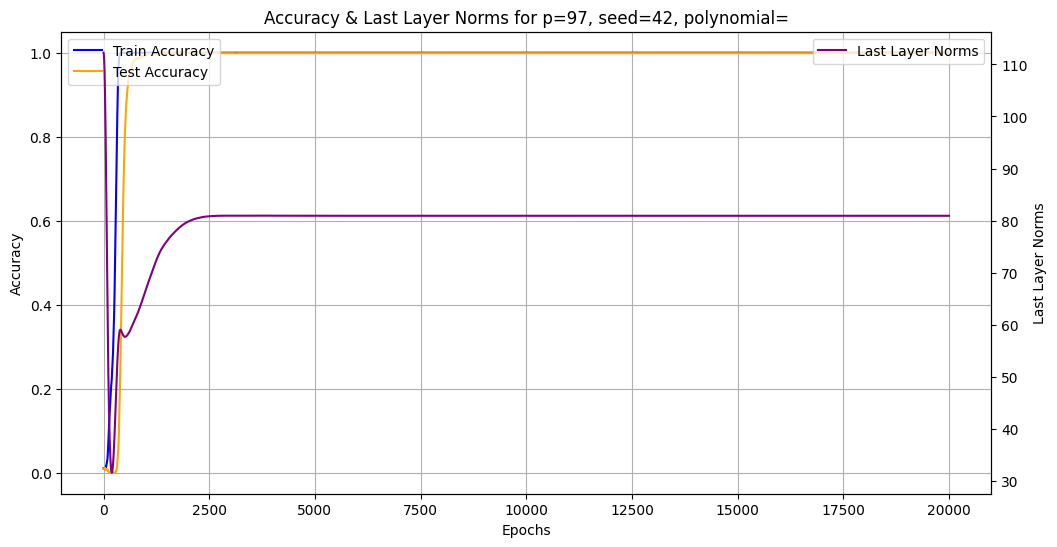

In [31]:
def plot_accuracy_with_dual_axis(train_accuracies, test_accuracies, last_layer_norms, p, seed, start_epoch=1, end_epoch=None, operation=""):
    # If end_epoch is not specified, use the length of one of the lists
    if end_epoch is None:
        end_epoch = len(train_accuracies)

    plt.figure(figsize=(12, 6))

    # Slice the lists to the specified range
    epochs_range = range(start_epoch, end_epoch + 1)

    # Plot accuracies on the primary y-axis
    plt.plot(epochs_range, train_accuracies[start_epoch-1:end_epoch], label='Train Accuracy', color='blue')
    plt.plot(epochs_range, test_accuracies[start_epoch-1:end_epoch], label='Test Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title(f'Accuracy & Last Layer Norms for p={p}, seed={seed}, polynomial={operation}')

    # Create secondary y-axis for last layer norms
    ax2 = plt.gca().twinx()
    ax2.plot(epochs_range, last_layer_norms[start_epoch-1:end_epoch], color='purple', label='Last Layer Norms')
    ax2.set_ylabel('Last Layer Norms')
    ax2.legend(loc='upper right')

    plt.show()

# Return the modified function for reference
plot_accuracy_with_dual_axis(train_accuracies, test_accuracies, last_layer_norms, p, seed, start_epoch=1, end_epoch=20000)
